<a href="https://www.kaggle.com/code/salilapte/image-caption-vit-generator?scriptVersionId=229178086" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 167MB/s] 


Epoch 1/10, Loss: 4.4506
Epoch 2/10, Loss: 3.6252
Epoch 3/10, Loss: 3.3031
Epoch 4/10, Loss: 3.1069
Epoch 5/10, Loss: 2.9491
Epoch 6/10, Loss: 2.8452
Epoch 7/10, Loss: 2.8159
Epoch 8/10, Loss: 2.7204
Epoch 9/10, Loss: 2.6345
Epoch 10/10, Loss: 2.5711


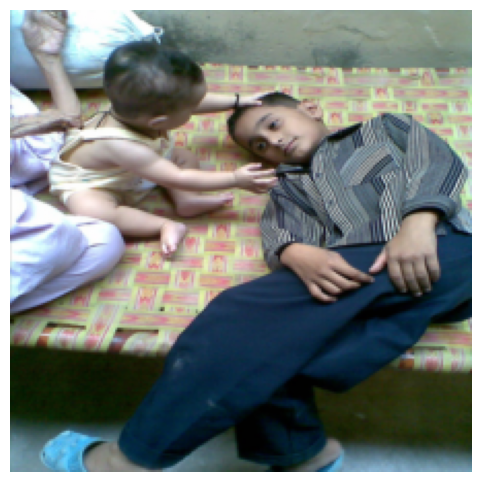

Generated Caption: the woman in the street with head at

Actual Caption: An infant sitting on a cot reaching over to touch the face of an older boy .

Similarity Score: 0.0880



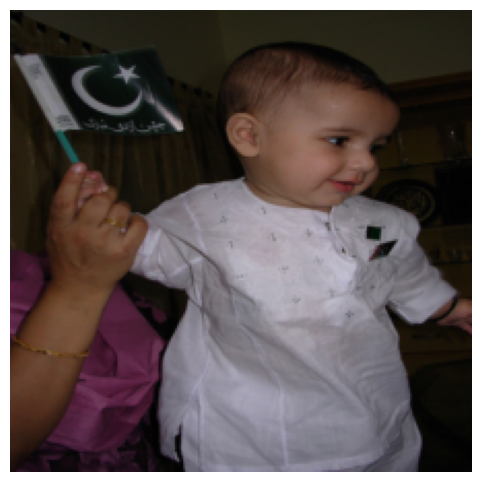

Generated Caption: a young boy with a small boy who

Actual Caption: A baby in a white garment holds a flag with crescent moon and star .

Similarity Score: 0.0570



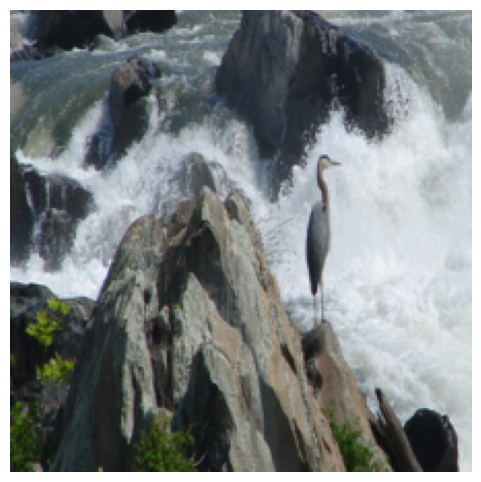

Generated Caption: a man <UNK> over a rock while a

Actual Caption: A bird is standing on a rock overlooking a waterfall .

Similarity Score: 0.0935



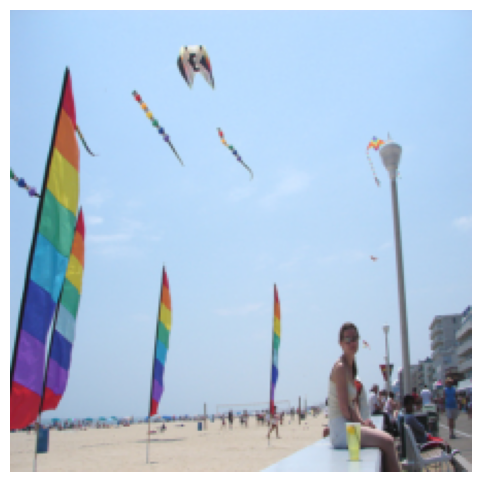

Generated Caption: a young young boy walks down a of

Actual Caption: A girl on a beach with rainbow flags .

Similarity Score: 0.0000



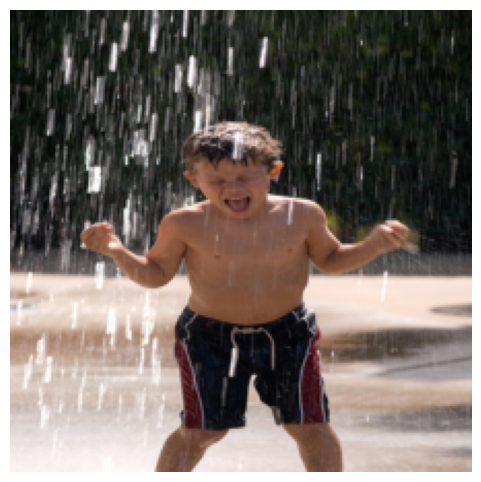

Generated Caption: a man in denim on a blue jacket

Actual Caption: A boy in bathing trunks is standing under a water shower .

Similarity Score: 0.0740



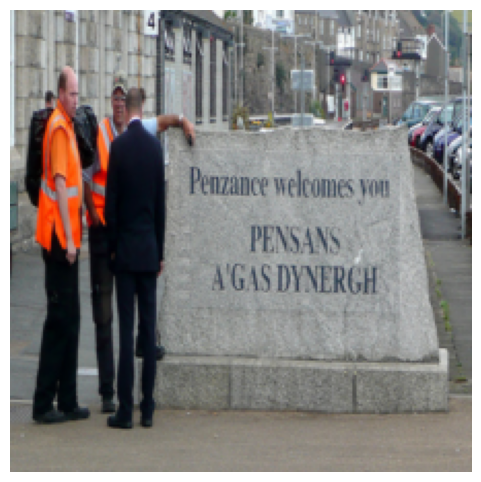

Generated Caption: people performing in a field .

Actual Caption: men are standing beside a stonesign

Similarity Score: 0.0000



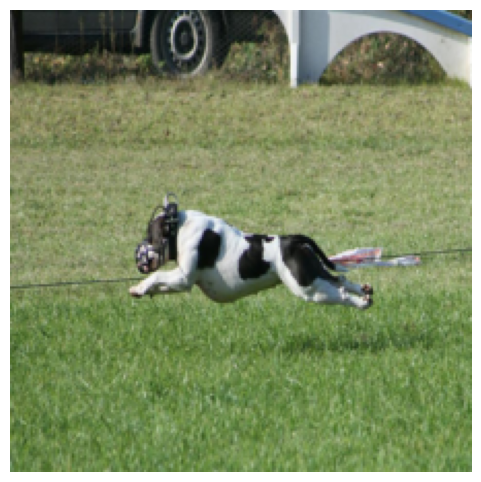

Generated Caption: a dog and a small watching a black

Actual Caption: A black and white dog is jumping in the grass .

Similarity Score: 0.2953



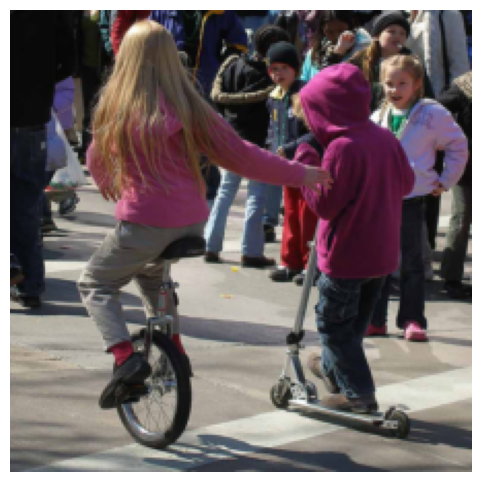

Generated Caption: a girl with a striped and her .

Actual Caption: A young girl rides a unicycle next to another riding a scooter on a busy street .

Similarity Score: 0.0703



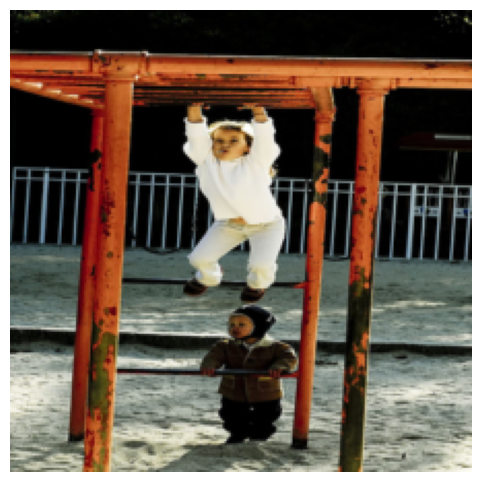

Generated Caption: two children jumping on a bars at a

Actual Caption: Two children playing on a jungle gym .

Similarity Score: 0.3361



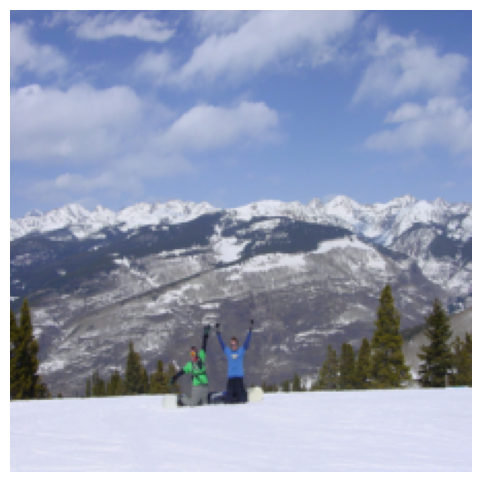

Generated Caption: the person in a green jacket walks tights

Actual Caption: Two men raise their arms atop a snowy mountain .

Similarity Score: 0.0000



In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from torchvision.models.vision_transformer import vit_b_16
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
nltk.download('punkt')

# Load a pre-trained Vision Transformer (ViT) model for feature extraction
from torchvision.models.vision_transformer import ViT_B_16_Weights

class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vit_weights = ViT_B_16_Weights.DEFAULT
        vit = vit_b_16(weights=vit_weights)
        self.encoder = vit.encoder
        self.conv_proj = vit.conv_proj
        self.cls_token = vit.class_token
        self.pos_embedding = vit.encoder.pos_embedding
        self.fc = nn.Linear(768, 512)  # Project CLS token output

    def forward(self, x):
        with torch.no_grad():
            x = self.conv_proj(x)  # [B, 768, 14, 14]
            x = x.flatten(2).transpose(1, 2)  # [B, N, 768]
            batch_size = x.size(0)
            cls_tokens = self.cls_token.expand(batch_size, -1, -1)
            x = torch.cat((cls_tokens, x), dim=1)
            x = x + self.pos_embedding[:, : x.size(1)]
            x = self.encoder(x)
            features = x[:, 0, :]  # Use [CLS] token
        return self.fc(features)

# Define Transformer-based caption generator
class CaptionGenerator(nn.Module):
    def __init__(self, feature_size=512, hidden_size=512, vocab_size=2002, num_layers=2, num_heads=8):
        super(CaptionGenerator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 50, hidden_size))  # Positional Encoding
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=hidden_size, nhead=num_heads), num_layers
        )
        self.fc = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, features, captions):
        captions = torch.clamp(captions, min=0, max=2001)
        captions = self.embedding(captions) + self.pos_encoder[:, :captions.size(1), :]
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(captions.size(1)).to(captions.device)
        tgt_mask = tgt_mask[:captions.size(1), :captions.size(1)]  # Ensure correct size
        output = self.transformer_decoder(captions.permute(1, 0, 2), features.unsqueeze(0), tgt_mask).permute(1, 0, 2)
        return self.fc(output)

# Dataset for Flickr8k with caption preprocessing
class Flickr8kDataset(Dataset):
    def __init__(self, image_dir, captions_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.captions_df = pd.read_csv(captions_file)
        self.image_files = list(self.captions_df['image'].unique())[:3000]
        self.captions = {img: self.captions_df[self.captions_df['image'] == img]['caption'].tolist() for img in self.image_files}

        # Build vocabulary
        all_tokens = [word_tokenize(c.lower()) for captions in self.captions.values() for c in captions]
        word_counts = Counter([word for caption in all_tokens for word in caption])
        self.vocab = {word: i + 4 for i, (word, _) in enumerate(word_counts.most_common(2000))}
        self.vocab["<UNK>"] = 1
        self.vocab["<PAD>"] = 0
        self.vocab["<SOS>"] = 2
        self.vocab["<EOS>"] = 3
        self.idx_to_word = {idx: word for word, idx in self.vocab.items()}

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(image_path).convert('RGB')
        actual_captions = self.captions[self.image_files[idx]]  # List of captions
        if self.transform:
            image = self.transform(image)
        return image, actual_captions

# Custom collate function to handle batching
def collate_fn(batch):
    images, captions = zip(*batch)
    images = torch.stack(images, dim=0)
    return images, captions

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load dataset
image_dir = "/kaggle/input/flickr8k/Images"
captions_file = "/kaggle/input/flickr8k/captions.txt"
# Reduce dataset size for quick testing
dataset = torch.utils.data.Subset(Flickr8kDataset(image_dir, captions_file, transform=transform), range(1000))
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

# Initialize models
feature_extractor = FeatureExtractor()
vocab_size = len(dataset.dataset.vocab)
caption_model = CaptionGenerator(vocab_size=vocab_size)
optimizer = optim.Adam(caption_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)

epochs = 10

# Train the caption model efficiently
caption_model.train()
for epoch in range(epochs):
    total_loss = 0
    for images, actual_captions in dataloader:
        features = feature_extractor(images)
        optimizer.zero_grad()
            # Prepare inputs using real tokenized captions
        tokenized_captions = []
        for caps in actual_captions:
            selected_caption = random.choice(caps)
            tokens = [dataset.dataset.vocab.get(word, 1) for word in word_tokenize(selected_caption.lower())[:8]]
            tokens = [2] + tokens + [3]  # Add <SOS> and <EOS>
            tokenized_captions.append(torch.tensor(tokens))
        padded = nn.utils.rnn.pad_sequence(tokenized_captions, batch_first=True, padding_value=0)
        inputs = padded[:, :-1]
        targets = padded[:, 1:]
        output = caption_model(features, inputs)  # Dummy captions for training
        loss = criterion(output.view(-1, output.shape[-1]), targets.contiguous().view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}")

# Set model to evaluation mode
caption_model.eval()

# Generate captions and compare with actual captions
vectorizer = TfidfVectorizer()
selected_indices = random.sample(range(len(dataset)), 10)
selected_images = [dataset[i] for i in selected_indices]
for image, actual_captions in selected_images:
    features = feature_extractor(image.unsqueeze(0))
    caption = [2]
    for _ in range(10):
        input_seq = torch.tensor(caption).unsqueeze(0)
        output = caption_model(features, input_seq)
        probs = torch.softmax(output[:, -1, :], dim=-1).squeeze(0)
        next_word = torch.multinomial(probs, 1).item()
        if next_word == 3:
            break
        caption.append(next_word)
    
    generated_caption = " ".join([dataset.dataset.idx_to_word.get(idx, "<UNK>") for idx in caption[1:]])
    actual_caption_text = random.choice(actual_captions)  # Select a random actual caption
    
    # Convert text to numerical vectors for similarity comparison
    tfidf_matrix = vectorizer.fit_transform([generated_caption, actual_caption_text])
    similarity_score = (tfidf_matrix * tfidf_matrix.T).toarray()[0, 1]
    
    plt.figure(figsize=(6, 6))
    plt.imshow(image.permute(1, 2, 0).numpy())
    plt.axis("off")
    plt.show()
    print(f"Generated Caption: {generated_caption}\n")
    print(f"Actual Caption: {actual_caption_text}\n")
    print(f"Similarity Score: {similarity_score:.4f}\n")